In [18]:
# Section 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import os
import json
import re
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo
from dotenv import load_dotenv
from openai import OpenAI

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load and preprocess dataset
dataset = fetch_ucirepo(id=69)  # Gene splicing dataset
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define search space
activation_options = ['identity', 'logistic', 'tanh', 'relu']
solver_options = ['lbfgs', 'sgd', 'adam']
lb = [5, 1e-4, 1e-6, 0, 0]
ub = [200, 1.0, 1.0, 3, 2]
bounds = (np.array(lb), np.array(ub))

# Section 2: GPT helper

def extract_json_list(text):
    match = re.search(r'\[.*\]', text, re.DOTALL)
    if match:
        return json.loads(match.group())
    raise ValueError("No valid JSON list found")

def query_gpt_for_particles(history, num_particles=3):
    prompt = f"""
You are optimizing MLP hyperparameters.
Here are past top configurations:
{history}

Now return ONLY a JSON list with {num_particles} new configurations like:
[{{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}}]

Only output the list. Do not add any explanation.
"""
    response = client.chat.completions.create(
        model="gpt-4-1106-preview",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    return extract_json_list(response.choices[0].message.content)

# Section 3: Baseline PSO objective
accuracy_history = []
best_so_far_history = []

def objective_mlp(swarm):
    global accuracy_history, best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    best_acc = -min(results)
    accuracy_history.append(best_acc)
    best_so_far_history.append(max(best_acc, best_so_far_history[-1]) if best_so_far_history else best_acc)
    return np.array(results)

# Section 4: LLM-enhanced PSO objective
llm_accuracy_history = []
llm_best_so_far_history = []

def objective_mlp_with_llm(swarm):
    global llm_accuracy_history, llm_best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    if len(llm_accuracy_history) % 5 == 0 and len(llm_accuracy_history) > 0:
        best_indices = np.argsort(results)[:3]
        history = [f"{list(swarm[i])} => {-results[i]:.4f}" for i in best_indices]
        new_particles = query_gpt_for_particles(history, num_particles=3)
        for i, new_p in zip(best_indices, new_particles):
            swarm[i] = [
                new_p['hidden'], new_p['lr'], new_p['alpha'], new_p['activation'], new_p['solver']
            ]

    best_acc = -min(results)
    llm_accuracy_history.append(best_acc)
    llm_best_so_far_history.append(max(best_acc, llm_best_so_far_history[-1]) if llm_best_so_far_history else best_acc)
    return np.array(results)


In [20]:
print("Running baseline PSO...")
accuracy_history, best_so_far_history = [], []
optimizer = GlobalBestPSO(n_particles=15, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.5}, bounds=bounds)
optimizer.optimize(objective_mlp, iters=30)

2025-04-13 10:41:34,224 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}


Running baseline PSO...


pyswarms.single.global_best:  27%|██▋       |8/30, best_cost=-0.914C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:  40%|████      |12/30, best_cost=-0.915C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: overflow encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.923
2025-04-13 

(-0.9231974921630094,
 array([169.44369129,   0.4277543 ,   0.71554547,   0.91978478,
          0.23805873]))

In [21]:
print("Running PSO + GPT...")
llm_accuracy_history, llm_best_so_far_history = [], []
optimizer = GlobalBestPSO(n_particles=15, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.5}, bounds=bounds)
optimizer.optimize(objective_mlp_with_llm, iters=30)

2025-04-13 10:48:40,656 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}


Running PSO + GPT...


pyswarms.single.global_best:   0%|          |0/30C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:  17%|█▋        |5/30, best_cost=-0.92 2025-04-13 10:50:30,698 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  20%|██        |6/30, best_cost=-0.92C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: overflow encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: Runtime

(-0.9200626959247649,
 array([147.67853516,   0.77199979,   0.67317543,   1.45799946,
          0.21954305]))

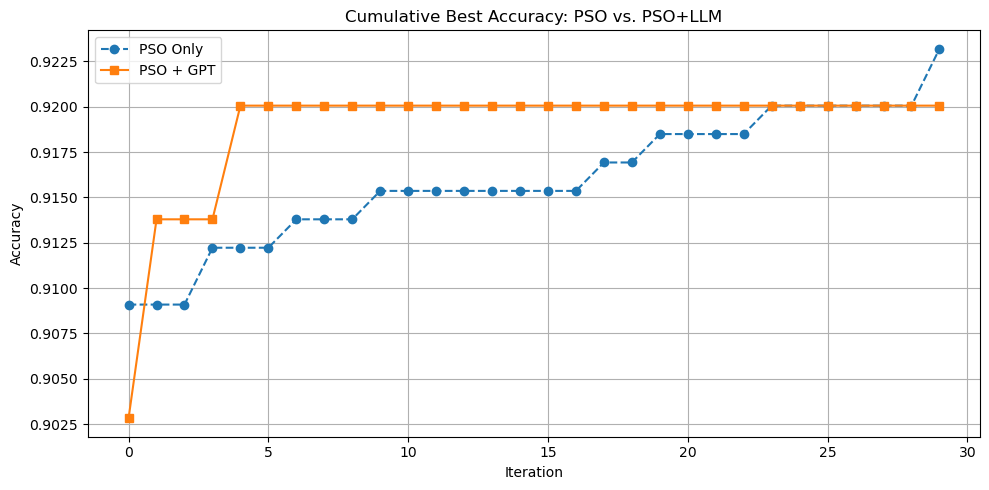

In [22]:
# Section 6: Visualization
plt.figure(figsize=(10, 5))
plt.plot(best_so_far_history, label="PSO Only", linestyle='--', marker='o')
plt.plot(llm_best_so_far_history, label="PSO + GPT", marker='s')
plt.title("Cumulative Best Accuracy: PSO vs. PSO+LLM")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()